# This is just a notebook to visualise 1kHz filtered raw data

In [1]:
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
import scipy
from scipy import interpolate
from scipy import fftpack
from scipy import signal

import mmap
import xarray as xr
import dask.array as da
%matplotlib widget


from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer, InMemoryAnalogSignalSource


/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_33390/318693299.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Load RawDataChannelExtractedDS.npy

In [1]:

def other_mmap(filename, shape, dtype, chunks):
    with open(filename, "rb") as fh:
        # `mmap` duplicates the file descriptor
        # `0` means map the full file
        mm = mmap.mmap(fh.fileno(), 0, access=mmap.ACCESS_READ)

    # coerce to NumPy array of expected type and shape
    a = np.asarray(mm).view(dtype).reshape(shape)

    # Don't call `asarray`
    # name=False to avoid hashing
    a_d = da.from_array(a, chunks=chunks, asarray=False, name=False)
    return a_d

souris = 'bleu'
#folder_base = Path('/Volumes/waking/audrey_hay/NPX/NPX4_claustrum/Expe_2024-07-18_12-49-00/')
#mb://10.69.168.1/waking/audrey_hay/NPX/NPX4_claustrum/Expe_2024-07-18_12-49-00/
#folder_base = Path('/Users/ahay/Documents/DATA/NecabChR2/AMOUREUX/')#RecordNode133/experiment1/recording1/continuous/Acquisition_Board-135RhythmData-B/')
folder_base = Path(f'/Users/ahay/Documents/DATA/AHCR/{souris}/20240220')
#folder_base = Path(f'/Users/ahay/Documents/DATA/OPPK/{souris}/')

#filename = folder_base / f'OE_32ch_data_2024-07-18T12_52_11.bin'
#All = np.fromfile('/Volumes/waking/audrey_hay/NPX/NPX4_claustrum/Expe_2024-07-18_12-49-00/OE_32ch_data_2024-07-18T12_52_11.bin', dtype="uint16")
#filename = folder_base / f'continuous.dat'
#filename = folder_base / f'LFPwake0.npy'
#filename = folder_base / f'SignalCA1.npy'
#All = np.fromfile(filename, dtype="int16")
#All2 = All.reshape(-1,64)
#All = np.load(filename, mmap_mode= 'r')


#All = All
filename = folder_base / f'LFPwakeremoved.npy'
All2 = np.load(filename, mmap_mode= 'r')
All2 = All2
#All2 = All2[500000:600000,:]
list_rec = 32
All2.shape

#folder_base2 = Path(f'/Volumes/waking/audrey_hay/NPX/{souris}/Reuniens/Expe_2024-07-24_18-40-02/')

#filename2 = folder_base2 / f'NP_spikes_2024-07-24T18_40_02.raw'

#data = other_mmap(filename2, (-1, 384), "uint16", chunks=(-1, 2))
#data2 = data[15000000:18000000,250:270]
#data3 = data[15000000:18000000,270:290]



NameError: name 'Path' is not defined

In [60]:
list_rawchan = np.append(data2, data3, axis = 1)
list_rawchan2 = list_rawchan.T
list_rawchan2


dask.array<transpose, shape=(40, 3000000), dtype=uint16, chunksize=(2, 3000000), chunktype=numpy.ndarray>

In [16]:
list_rawchan = np.append(data2, data3, axis = 1)
list_rawchan2 = list_rawchan.T
list_rawchan_filt = []
for ele, file in enumerate(list_rawchan2):
    print(file)
    list_rawchan_filt.append(file)

list_rawchan = None

filename2 = folder_base / f'NPX32Channels.npy'
np.save(filename2, list_rawchan_filt)

NameError: name 'data2' is not defined

In [12]:
filename = folder_base / f'NPX200-220_240-260_Channels.npy'
All4 = np.load(filename, mmap_mode= 'r')
All4 = All4.T
All4.shape

(3000000, 40)

In [49]:
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer
from ephyviewer import InMemoryAnalogSignalSource

app = mkQApp()

sample_rate = 1000.
t_start = 0.

win = MainViewer()
view1 = TraceViewer.from_numpy(All2, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
view1.params['display_labels'] = True

#And also parameters for each channel
for i in range(list_rec):
    channel = f'ch{i}'
    view1.by_channel_params[channel, 'gain'] = 0.001
    view1.by_channel_params[channel, 'offset'] = list_rec - 2*(i+1)
#Run
win.show()
app.exec_()

0

In [3]:
if souris == 'jaune':
    EMG = All2[:, 21]                   #EMG (Jaune)
    A1 = All2[:, 3] - All2[:, 2]        #CA1
    A2 = All2[:, 4] - All2[:, 5]        #RSP *
    A3 = All2[:, 6] - All2[:, 7]        #Par
    A4 = All2[:, 8] #- All2[:, 9]        #PFC *
    A5 = All2[:, 10] - All2[:, 11]      #M1 *
    A6 = All2[:, 13] - All2[:, 12]      #OFC
    A7 = All2[:, 30] - All2[:, 31]      #mEC
    A8 = All2[:, 28] - All2[:, 29]      #Perirhinal
    A9 = All2[:, 17] #- All2[:, 16]      #BLA
    A10 = All2[:, 14] - All2[:, 15]     #S1 *
    label = ['EMG','CA1','RSP','Par','PFC','M1','OFC','mEC','Perirhinal','BLA','S1']
elif souris == 'violet': ## Joli et fait
    EMG = All2[:, 5]                    #EMG (violet)
    A1 = All2[:, 23] - All2[:, 22]      #RSP
    A2 = All2[:, 21] - All2[:, 20]      #Par
    A3 = All2[:, 18] - All2[:, 19]      #CA1 +
    A4 = All2[:, 24] #- All2[:, 25]      #PFC *
    A5 = All2[:, 26] - All2[:, 27]      #M1 *
    A6 = All2[:, 28] - All2[:, 29]      #OFC *
    A7 = All2[:, 30] - All2[:, 31]      #S1 *
    A8 = All2[:, 0] - All2[:, 1]        #Perirhinal
    A11 = All2[:, 16] - All2[:, 17]      #CA1
    A10 = All2[:, 14] -  All2[:, 15]     #BLA
    A9 = All2[:, 13] #- All2[:, 12]       #mEC
    label = ['EMG','RSP','Par','CA1','PFC','M1','OFC','S1','Perirhinal','BLA','mEC']
elif souris == 'vert':
    EMG = All2[:, 26]                    #EMG (vert)
    A1 = All2[:, 2] - All2[:, 3]        #Par
    A2 = All2[:, 4] - All2[:, 5]        #PFC
    A3 = All2[:, 7] - All2[:, 6]        #OFC 
    A4 = All2[:, 8] - All2[:, 9]        #S1 *
    A5 = All2[:, 10] - All2[:, 11]      #BLA
    A6 = All2[:, 12] - All2[:, 13]      #mEC +
    A7 = All2[:, 29] #- All2[:, 29]      #CA1
    A8 = All2[:, 0] - All2[:, 1]        #M1
    A9 = All2[:, 16] - All2[:, 17]      #RSP +
    A10 = All2[:, 14] - All2[:, 15]     #Perirhinal
elif souris == 'orange':
    EMG = All2[:, 25]                    #EMG (orange)
    A1 = All2[:, 6] - All2[:, 7]         #Par
    A2 = All2[:, 11] - All2[:, 10]       #PFC *
    A3 = All2[:, 8] - All2[:, 9]         #OFC *
    A4 = All2[:, 17] - All2[:, 16]       #S1 *
    A5 = All2[:, 14] - All2[:, 15]       #BLA
    A6 = All2[:, 0] - All2[:, 1]         #mEC
    A7 = All2[:, 27] - All2[:, 29]       #CA1
    A8 = All2[:, 13] - All2[:, 12]       #M1 *
    A9 = All2[:, 4] - All2[:, 3]         #RSP
    A10 = All2[:, 18] - All2[:, 19]      #Perirhinal
elif souris == 'bleu':
    EMG = All2[:, 20]                    #EMG (bleu)
    A1 = All2[:, 5] - All2[:, 4]         #Par * DS~
    A2 = All2[:, 14] - All2[:, 15]       #PFC * chan 15
    A3 = All2[:, 12] - All2[:, 13]       #OFC *
    A4 = All2[:, 9] - All2[:, 8]         #S1 * DS+
    A5 = All2[:, 10] - All2[:, 11]       #BLA
    A6 = All2[:, 2] - All2[:, 3]         #mEC +
    A7 = All2[:, 30]# - All2[:, 30]       #CA1 +
    A8 = All2[:, 16] -  All2[:, 17]       #M1 * DS+
    A9 = All2[:, 0] - All2[:, 1]         #RSP
    A10 = All2[:, 6] - All2[:, 7]        #Perirhinal +
elif souris == 'bleu2':
    EMG = All2[:, 2]                    #EMG (bleu)
    A1 = All2[:, 5] - All2[:, 4]         #Par
    A2 = All2[:, 1] - All2[:, 1]       #PFC
    A3 = All2[:, 14] - All2[:, 15]       #OFC
    A4 = All2[:, 14]# - All2[:, 8]         #S1
    A5 = All2[:, 15]# - All2[:, 11]       #BLA
    A6 = All2[:, 5] - All2[:, 4]         #mEC
    A7 = All2[:, 0]# - All2[:, 30]       #CA1
    A8 = All2[:, 6] -  All2[:, 7]       #M1
    A9 = All2[:, 1] - All2[:, 0]         #RSP
    A10 = All2[:, 6] - All2[:, 7]        #Perirhinal
elif souris == '2205':
    EMG = All2[:, 6]                    #EMG (2205)
    A1 = All2[:, 31] - All2[:, 30]      #M1
    A2 = All2[:, 21] - All2[:, 20]      #M2
    A3 = All2[:, 18] - All2[:, 19]      #CA1 +
    A4 = All2[:, 14] - All2[:, 14]      #CA12 *
    A5 = -All2[:, 2]# - All2[:, 3]      #S1 *
    A6 = All2[:, 29] - All2[:, 28]      #S1 *
    A7 = All2[:, 30] - All2[:, 30]      #S1 *
    A8 = All2[:, 0] - All2[:, 0]        #Perirhinal
    A11 = All2[:, 16] - All2[:, 16]      #CA1
    A10 = All2[:, 14] -  All2[:, 14]     #BLA
    A9 = All2[:, 13] - All2[:, 13]       #mEC
    label = ['EMG','RSP','Par','CA1','PFC','M1','OFC','S1','Perirhinal','BLA','mEC']
elif souris == 'M19': ## OPPK long stim
    EMG = All2[:, 6]                    #EMG (M19)
    A1 = All2[:, 25] - All2[:, 24]      #front
    A2 = All2[:, 21] - All2[:, 20]      #M1
    A3 = All2[:, 19] - All2[:, 18]      #M2
    A3 = All2[:, 12] - All2[:, 13]      #CA1ipsi
    A4 = All2[:, 15] - All2[:, 14]      #S1tr
    A5 = All2[:, 11] - All2[:, 10]      #S1bf
    A6 = All2[:, 26] - All2[:, 27]      #S1contra
    A7 = All2[:, 16] - All2[:, 17]      #S1fl
    A8 = All2[:, 0] - All2[:, 1]        #RSA
    A9 = All2[:, 9] - All2[:, 8]        #Aud
    A10 = All2[:, 23] -  All2[:, 22]    #M2
    A11 = All2[:, 3] - All2[:, 2]       #V1
    A12 = All2[:, 4] - All2[:, 5]       #V2
    A12 = All2[:, 30] - All2[:, 31]       #CA1contra
    label = ['EMG','RSP','Par','CA1','PFC','M1','OFC','S1','Perirhinal','BLA','mEC']
elif souris == 'alien': # à analyser
    EMG = All2[:, 7]                    #EMG (alien)
    A1 = All2[:, 28] - All2[:, 29]         #Par *
    A2 = All2[:, 1] - All2[:, 0]       #PFC *
    A3 = All2[:, 18] - All2[:, 19]       #OFC
    A4 = All2[:, 14] - All2[:, 15]         #S1 *
    A5 = All2[:, 24] - All2[:, 25]       #BLA
    A6 = All2[:, 22] #- All2[:, 23]         #mEC
    A7 = All2[:, 2] - All2[:, 3]       #CA1 +
    A8 = All2[:, 10] -  All2[:, 11]       #M1 *
    A9 = All2[:, 5] - All2[:, 4]         #RSP *
    A10 = All2[:, 7]# - All2[:, 3]        #VIDE
elif souris == 'apaiser': # A analyser 
    EMG = All2[:, 6]                    #EMG (apaiser)
    A1 = All2[:, 28] - All2[:, 27]      #Par *
    A2 = All2[:, 24] #- All2[:, 25]       #PFC *
    A3 = All2[:, 19] - All2[:, 20]       #OFC *
    A4 = All2[:, 22] - All2[:, 23]         #S1 *
    A5 = All2[:, 15] - All2[:, 16]       #BLA
    A6 = All2[:, 11] - All2[:, 12]         #mEC +
    A7 = All2[:, 0] - All2[:, 31]       #CA1 +
    A8 = All2[:, 1] #-  All2[:, 2]       #M1 *
    A9 = All2[:, 4] - All2[:, 3]         #RSP
    A10 = All2[:, 6]# - All2[:, 3]        #VIDE
elif souris == 'pervers':
    EMG = All2[:, 24]                    #EMG (pervers)
    A1 = All2[:, 17] - All2[:, 16]         #Par *
    A2 = All2[:, 12] - All2[:, 13]       #PFC
    A3 = All2[:, 8] - All2[:, 9]       #OFC
    A4 = All2[:, 3] - All2[:, 2]         #S1 *
    A5 = All2[:, 28] - All2[:, 29]       #BLA
    A6 = All2[:, 27] - All2[:, 26]         #mEC
    A7 = All2[:, 22] - All2[:, 23]       #CA1 ~+
    A8 = All2[:, 7] -  All2[:, 6]       #M1 *
    A9 = All2[:, 19] - All2[:, 18]         #RSP
    A10 = All2[:, 30] - All2[:, 31]        #Perirhinal +
elif souris == 'sleepy':
    EMG = All2[:, 7]                    #EMG (sleepy)
    A1 = All2[:, 0] - All2[:, 1]         #Par
    A2 = All2[:, 3] - All2[:, 2]       #PFC +
    A3 = All2[:, 4] - All2[:, 5]       #OFC
    A4 = All2[:, 14] #- All2[:, 15]         #S1
    A5 = All2[:, 18] - All2[:, 19]       #BLA
    A6 = All2[:, 22] - All2[:, 23]         #mEC
    A7 = All2[:, 28] - All2[:, 29]       #CA1
    A8 = All2[:, 10] #-  All2[:, 11]       #M1
    A9 = All2[:, 24] - All2[:, 25]         #RSP
    A10 = All2[:, 20] - All2[:, 21]        #Perirhinal
elif souris == 'intello':
    EMG = All2[:, 23]                    #EMG (intello)
    A1 = All2[:, 8] - All2[:, 9]         #Par
    A2 = All2[:, 5] - All2[:, 4]       #PFC
    A3 = All2[:, 6] - All2[:, 7]       #OFC
    A4 = All2[:, 18] - All2[:, 19]         #S1
    A5 = All2[:, 20] - All2[:, 21]       #BLA
    A6 = All2[:, 26] - All2[:, 27]         #mEC
    A7 = All2[:, 12] - All2[:, 13]       #CA1
    A8 = All2[:, 30] -  All2[:, 31]       #M1
    A9 = All2[:, 17] - All2[:, 16]         #RSP
    A10 = All2[:, 2] - All2[:, 3]        #Perirhinal  +  
elif souris == 'chokbar':
    EMG = All2[:, 23]                    #EMG (chokbar)
    A1 = All2[:, 16] - All2[:, 17]         #Par * ch16
    A2 = All2[:, 8] - All2[:, 9]       #PFC * ch8
    A3 = All2[:, 6] - All2[:, 7]       #OFC
    A4 = All2[:, 4] - All2[:, 5]         #S1 *
    A5 = All2[:, 2] - All2[:, 3]       #BLA
    A6 = All2[:, 26] - All2[:, 27]         #mEC
    A7 = All2[:, 20] - All2[:, 21]       #CA1
    A8 = All2[:, 12] -  All2[:, 13]       #M1
    A9 = All2[:, 18] - All2[:, 19]         #RSP
    A10 = All2[:, 30] - All2[:, 31]        #Perirhinal +  
elif souris == 'amoureux':
    EMG = All2[:, 7]                    #EMG (amoureux) À analyser pour CA1, mais vraiment rien sur les autres
    A1 = All2[:, 5] #- All2[:, 4]         #Par
    A2 = All2[:, 15] - All2[:, 14]       #PFC *
    A3 = All2[:, 0] - All2[:, 1]       #OFC
    A4 = All2[:, 3] - All2[:, 2]         #S1 *
    A5 = All2[:, 22] - All2[:, 23]       #BLA
    A6 = All2[:, 24] - All2[:, 25]         #mEC
    A7 = All2[:, 21] - All2[:, 20]       #CA1 +
    A8 = All2[:, 18] -  All2[:, 19]       #M1 *
    A9 = All2[:, 11] - All2[:, 10]         #RSP
    A10 = All2[:, 28] - All2[:, 29]        #Perirhinal 
elif souris == 'evil':
    EMG = All2[:, 7]                    #EMG (evil)
    A1 = All2[:, 3] - All2[:, 2]         #Par * moche, pas forcément crédible
    A2 = All2[:, 25] - All2[:, 24]       #PFC *
    A3 = All2[:, 22] - All2[:, 23]       #OFC *
    A4 = All2[:, 4] - All2[:, 5]         #S1 *
    A5 = All2[:, 18] - All2[:, 19]       #BLA
    A6 = All2[:, 10] - All2[:, 11]         #mEC
    A7 = All2[:, 20] - All2[:, 21]       #CA1 +
    A8 = All2[:, 28] -  All2[:, 29]       #M1 *
    A9 = All2[:, 1] - All2[:, 0]         #RSP
    A10 = All2[:, 14] - All2[:, 15]        #Perirhinal  +
elif souris == 'explode':
    EMG = All2[:, 7]                    #EMG (explode) sadly no spindles on Par, PFC, OFC and M1 even with 1 channel
    A1 = All2[:, 6] - All2[:, 5]         #Par
    A2 = All2[:, 10] - All2[:, 11]       #PFC
    A3 = All2[:, 6] - All2[:, 5]       #OFC
    A4 = All2[:, 1] - All2[:, 2]         #S1 *
    A5 = All2[:, 14] - All2[:, 15]       #BLA -> des moments de coordination avec CA1
    A6 = All2[:, 25] #- All2[:, 25]         #mEC
    A7 = All2[:, 19] - All2[:, 18]       #CA1 +
    A8 = All2[:, 4] -  All2[:, 3]       #M1 *
    A9 = All2[:, 22] - All2[:, 23]         #RSP
    A10 = All2[:, 30] - All2[:, 29]        #Perirhinal +   
elif souris == 'dead':
    EMG = All2[:, 7]                    #EMG (dead)
    A1 = All2[:, 4] - All2[:, 5]         #Par
    A2 = All2[:, 19] - All2[:, 18]       #PFC
    A3 = All2[:, 11] - All2[:, 10]       #OFC
    A4 = All2[:, 21] - All2[:, 20]         #S1
    A5 = All2[:, 22] - All2[:, 23]       #BLA
    A6 = All2[:, 24] #- All2[:, 25]         #mEC
    A7 = All2[:, 2] #- All2[:, 3]       #CA1 
    A8 = All2[:, 15] -  All2[:, 14]       #M1
    A9 = All2[:, 1] - All2[:, 0]         #RSP
    A10 = All2[:, 28] - All2[:, 29]        #Perirhinal +
elif souris == 'NPX4':
    EMG = All2[:, 6]                    #EMG (NPX4)
    A1 = All2[:, 25] - All2[:, 26]         #PFC
    A2 = All2[:, 22] - All2[:, 21]       #OFC
    A3 = All2[:, 28] - All2[:, 29]       #M2
    A4 = All2[:, 18] - All2[:, 19]         #M1
    A5 = All2[:, 17] - All2[:, 16]       #S1bf
    A6 = All2[:, 31] - All2[:, 30]         #S1fl
    A7 = All2[:, 1] - All2[:, 0]       #RSP
    A8 = All2[:, 3] -  All2[:, 4]       #CA1-1
    A9 = All2[:, 14] - All2[:, 15]         #CA1-2
    A11 = All2[:, 12] - All2[:, 13]        #V1
    A10 = All2[:, 10] - All2[:, 11]        #mec
elif souris == 'NPX3':
    EMG = All2[:, 6]                    #EMG (NPX3)
    A1 = All2[:, 25] - All2[:, 26]         #PFC
    A2 = All2[:, 21] - All2[:, 22]       #OFC
    A3 = All2[:, 28] - All2[:, 29]       #M2
    A4 = All2[:, 19] - All2[:, 18]         #M1
    A5 = All2[:, 17] - All2[:, 16]       #S1fl
    A6 = All2[:, 31] - All2[:, 30]         #RSP
    A7 = All2[:, 1] - All2[:, 0]       #CA1-1
    A8 = All2[:, 4] -  All2[:, 3]       #V1
    A9 = All2[:, 14] - All2[:, 15]         #CA1-2
    A10 = All2[:, 13] - All2[:, 12]        #S1bf
    A8 = All2[:, 10] - All2[:, 11]        #mEC
elif souris == 'NPX1':
    EMG = All2[:, 6]                    #EMG (NPX1)
    A1 = All2[:, 21] - All2[:, 20]         #PFC
    A2 = All2[:, 19] - All2[:, 18]       #OFC
    A3 = All2[:, 27] - All2[:, 26]       #M2
    A4 = All2[:, 16] - All2[:, 17]         #M1 -> DOWN States
    A5 = All2[:, 29] - All2[:, 28]       #S1fl
    A6 = All2[:, 30] - All2[:, 31]         #RSP
    A7 = All2[:, 1] - All2[:, 0]       #CA1-1
    A8 = All2[:, 11] -  All2[:, 10]       #V1
    A9 = All2[:, 2] - All2[:, 3]         #CA1-2
    A5 = All2[:, 14] - All2[:, 15]        #S1bf
    A10 = All2[:, 13] - All2[:, 12]        #mEC
elif souris == 'NPX5':
    EMG = All2[:, 6]                    #EMG (NPX5)
    A1 = All2[:, 25] - All2[:, 26]         #PFC
    A2 = All2[:, 22] - All2[:, 21]       #OFC
    A3 = All2[:, 28] - All2[:, 29]       #M2
    A4 = All2[:, 18] - All2[:, 19]         #M1
    A5 = All2[:, 17] - All2[:, 16]       #S1fl
    A6 = All2[:, 31] #- All2[:, 30]         #RSP
    A7 = All2[:, 1] - All2[:, 0]       #CA1-1
    A8 = All2[:, 3] -  All2[:, 4]       #CA1-2
    A9 = All2[:, 14] - All2[:, 15]         #S1bf
    A11 = All2[:, 12] - All2[:, 13]        #V1
    A10 = All2[:, 10] - All2[:, 11]        #mec
elif souris == 'NPX6':
    EMG = All2[:, 6]                    #EMG (NPX6)
    A1 = All2[:, 25] - All2[:, 26]         #PFC
    A2 = All2[:, 22] - All2[:, 21]       #OFC
    A3 = All2[:, 28] - All2[:, 29]       #M2
    A4 = All2[:, 19] - All2[:, 18]         #M1
    A5 = All2[:, 16] - All2[:, 17]       #S1fl
    A6 = All2[:, 31] #- All2[:, 30]         #RSP
    A7 = All2[:, 1] - All2[:, 0]       #CA1-1
    A8 = All2[:, 3] -  All2[:, 4]       #CA1-2
    A9 = All2[:, 15] - All2[:, 14]         #S1bf
    A11 = All2[:, 12] - All2[:, 13]        #V1
    A10 = All2[:, 10] - All2[:, 11]        #mec
    
L = [EMG, A1, A2, A3, A4, A5, A6, A7, A8, A9, A10]
All3 = np.concatenate(L, axis=0)
All3 = All3.reshape(11,-1)
All3 = All3.T

app = mkQApp()


sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(All3, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel

view1.by_channel_params['ch0', 'gain'] = 0.00005
view1.by_channel_params['ch1', 'gain'] = 0.00005
view1.by_channel_params['ch2', 'gain'] = 0.00005
view1.by_channel_params['ch3', 'gain'] = 0.00005
view1.by_channel_params['ch4', 'gain'] = 0.00005
view1.by_channel_params['ch5', 'gain'] = 0.00005
view1.by_channel_params['ch6', 'gain'] = 0.00005
view1.by_channel_params['ch7', 'gain'] = 0.00005
view1.by_channel_params['ch8', 'gain'] = 0.00005
view1.by_channel_params['ch9', 'gain'] = 0.00005
view1.by_channel_params['ch10', 'gain'] = 0.00005



view1.by_channel_params['ch0', 'offset'] = 0.5
view1.by_channel_params['ch1', 'offset'] = 0.4
view1.by_channel_params['ch2', 'offset'] = 0.3
view1.by_channel_params['ch3', 'offset'] = 0.2
view1.by_channel_params['ch4', 'offset'] = 0.1
view1.by_channel_params['ch5', 'offset'] = 0.0
view1.by_channel_params['ch6', 'offset'] = -0.1
view1.by_channel_params['ch7', 'offset'] = -0.2
view1.by_channel_params['ch8', 'offset'] = -0.3
view1.by_channel_params['ch9', 'offset'] = -0.4
view1.by_channel_params['ch10', 'offset'] = -0.5




#Run
win.show()
app.exec_()


0

In [65]:
from ephyviewer import InMemorySpikeSource
from ephyviewer import SpikeTrainViewer
from ephyviewer import InMemoryAnalogSignalSource
sigs = []
for c in range(11):
    sigs.append({ 'time':All3[:,c], 'name':label[c]})

win = MainViewer()
view1 = TraceViewer.from_numpy(sigs, sample_rate, t_start, 'Signals')
win.add_view(view1)
# source = InMemorySpikeSource(sigs)
# win = MainViewer(debug=True, show_auto_scale=True)
# view1 = SpikeTrainViewer(source=source)
view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True




NameError: name 'label' is not defined

In [10]:
filenameTTL = folder_base / f'TTLproperties.csv'
Timestamps = pd.read_csv(filenameTTL)
Timestamps['Start']

0        1224708
1        1244938
2        1255178
3        1260168
4        1265288
          ...   
1208    11110662
1209    11115912
1210    11122952
1211    11127942
1212    11133322
Name: Start, Length: 1213, dtype: int64

In [8]:


from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer

app = mkQApp()


sample_rate = 1000.
t_start = 0.

TTL = Timestamps

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: TTL, 1: TTL}
#and asign them to some channels each
scatter_channels = {0: [0, 12], 1: [0, 1]}
sources = AnalogSignalSourceWithScatter(All2, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 =  TraceViewer(source=sources)


# #Parameters can be set in script
# #view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
# #And also parameters for each channel

view1.by_channel_params['ch0', 'gain'] = 0.00002
view1.by_channel_params['ch1', 'gain'] = 0.00002
view1.by_channel_params['ch2', 'gain'] = 0.00002
view1.by_channel_params['ch3', 'gain'] = 0.00002
view1.by_channel_params['ch4', 'gain'] = 0.00002
view1.by_channel_params['ch5', 'gain'] = 0.00002
view1.by_channel_params['ch6', 'gain'] = 0.00002
view1.by_channel_params['ch7', 'gain'] = 0.00002
view1.by_channel_params['ch8', 'gain'] = 0.00002
view1.by_channel_params['ch9', 'gain'] = 0.00002
view1.by_channel_params['ch10', 'gain'] = 0.00002
view1.by_channel_params['ch11', 'gain'] = 0.00002
view1.by_channel_params['ch12', 'gain'] = 0.00002
view1.by_channel_params['ch13', 'gain'] = 0.00002
view1.by_channel_params['ch14', 'gain'] = 0.00002
view1.by_channel_params['ch15', 'gain'] = 0.00002
view1.by_channel_params['ch15', 'gain'] = 0.00002
view1.by_channel_params['ch15', 'gain'] = 0.00002
view1.by_channel_params['ch16', 'gain'] = 0.00002
view1.by_channel_params['ch17', 'gain'] = 0.00002
view1.by_channel_params['ch18', 'gain'] = 0.00002
view1.by_channel_params['ch19', 'gain'] = 0.00002
view1.by_channel_params['ch20', 'gain'] = 0.00002
view1.by_channel_params['ch21', 'gain'] = 0.00002
view1.by_channel_params['ch22', 'gain'] = 0.00002
view1.by_channel_params['ch23', 'gain'] = 0.00002
view1.by_channel_params['ch24', 'gain'] = 0.00002
view1.by_channel_params['ch25', 'gain'] = 0.00002
view1.by_channel_params['ch26', 'gain'] = 0.00002
view1.by_channel_params['ch27', 'gain'] = 0.00002
view1.by_channel_params['ch28', 'gain'] = 0.00002
view1.by_channel_params['ch29', 'gain'] = 0.00002
view1.by_channel_params['ch30', 'gain'] = 0.00002
view1.by_channel_params['ch31', 'gain'] = 0.00002

view1.by_channel_params['ch7', 'offset'] = 1.6
view1.by_channel_params['ch0', 'offset'] = 1.5
view1.by_channel_params['ch1', 'offset'] = 1.4
view1.by_channel_params['ch2', 'offset'] = 1.3
view1.by_channel_params['ch3', 'offset'] = 1.2
view1.by_channel_params['ch4', 'offset'] = 1.1
view1.by_channel_params['ch5', 'offset'] = 1
view1.by_channel_params['ch6', 'offset'] = 0.9
view1.by_channel_params['ch8', 'offset'] = 0.8
view1.by_channel_params['ch9', 'offset'] = 0.7
view1.by_channel_params['ch10', 'offset'] = 0.6
view1.by_channel_params['ch11', 'offset'] = 0.5
view1.by_channel_params['ch12', 'offset'] = 0.4
view1.by_channel_params['ch13', 'offset'] = 0.3
view1.by_channel_params['ch14', 'offset'] = 0.2
view1.by_channel_params['ch15', 'offset'] = 0.1
view1.by_channel_params['ch16', 'offset'] = 0.
view1.by_channel_params['ch17', 'offset'] = -0.1
view1.by_channel_params['ch18', 'offset'] = -0.2
view1.by_channel_params['ch19', 'offset'] = -0.3
view1.by_channel_params['ch20', 'offset'] = -0.4
view1.by_channel_params['ch21', 'offset'] = -0.5
view1.by_channel_params['ch22', 'offset'] = -0.6
view1.by_channel_params['ch23', 'offset'] = -0.7
view1.by_channel_params['ch24', 'offset'] = -0.8
view1.by_channel_params['ch25', 'offset'] = -0.9
view1.by_channel_params['ch26', 'offset'] = -1.
view1.by_channel_params['ch27', 'offset'] = -1.1
view1.by_channel_params['ch28', 'offset'] = -1.2
view1.by_channel_params['ch29', 'offset'] = -1.3
view1.by_channel_params['ch30', 'offset'] = -1.4
view1.by_channel_params['ch31', 'offset'] = -1.5

#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec_()

debug True
QT_MODE PyQt5
refresh duration for  0.00014901161193847656 s
refresh duration for  0.001188039779663086 s
refresh duration for  0.0008099079132080078 s
refresh duration for  0.0005400180816650391 s
refresh duration for  0.0004405975341796875 s
refresh duration for  0.0002319812774658203 s
refresh duration for  0.0001838207244873047 s
refresh duration for  0.0001800060272216797 s
refresh duration for  0.0001850128173828125 s
refresh duration for  0.000186920166015625 s
refresh duration for  0.0001819133758544922 s
refresh duration for  0.00020194053649902344 s
refresh duration for  0.00018310546875 s
refresh duration for  0.00017404556274414062 s
refresh duration for  0.0002040863037109375 s
refresh duration for  0.0002009868621826172 s
refresh duration for  0.0001709461212158203 s
refresh duration for  0.0001919269561767578 s
refresh duration for  0.00016689300537109375 s
refresh duration for  0.00015425682067871094 s
refresh duration for  0.00019788742065429688 s
refresh du

0

In [51]:
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer

app = mkQApp()


sample_rate = 1000.
t_start = 0.
#male032
A0 = All2[:, 20]                    #EMG
A1 = All2[:, 28] - All2[:, 30]      #CA1 *
A2 = All2[:, 5] #- All2[:, 4]      #A1 *
A3 = All2[:, 2] - All2[:, 3]      #RSP *
A4 = All2[:, 24] - All2[:, 26]      #eog *
A5 = All2[:, 12] - All2[:, 11]      #PFC *
A6 = All2[:, 14] - All2[:, 15]      #S1 *




L = [A0, A1, A2, A3, A4, A5, A6]#, A7, A8, A9, A10, A11, A12, A13, A14, A15]
All3 = np.concatenate(L, axis=0)
All3 = All3.reshape(7,-1)
All3 = All3.T


TTL = Timestamps 

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: TTL, 1: TTL}
#and asign them to some channels each
scatter_channels = {0: [0, 1], 1: [0, 1]}
sources = AnalogSignalSourceWithScatter(All3, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 =  TraceViewer(source=sources)


# #Parameters can be set in script
# #view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
# #And also parameters for each channel

view1.by_channel_params['ch0', 'gain'] = 0.00002
view1.by_channel_params['ch1', 'gain'] = 0.00002
view1.by_channel_params['ch2', 'gain'] = 0.00002
view1.by_channel_params['ch3', 'gain'] = 0.00002
view1.by_channel_params['ch4', 'gain'] = 0.00002
# view1.by_channel_params['ch5', 'gain'] = 0.00002
# view1.by_channel_params['ch6', 'gain'] = 0.00002
# view1.by_channel_params['ch7', 'gain'] = 0.00002
# view1.by_channel_params['ch8', 'gain'] = 0.00002
# view1.by_channel_params['ch9', 'gain'] = 0.00002
# view1.by_channel_params['ch10', 'gain'] = 0.00002
# view1.by_channel_params['ch11', 'gain'] = 0.00002
# view1.by_channel_params['ch12', 'gain'] = 0.00002
# view1.by_channel_params['ch13', 'gain'] = 0.00002
# view1.by_channel_params['ch14', 'gain'] = 0.00002



#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec_()

debug True
QT_MODE PyQt5
refresh duration for  5.5789947509765625e-05 s
refresh duration for  0.0006489753723144531 s
refresh duration for  8.797645568847656e-05 s
refresh duration for  0.00010991096496582031 s
refresh duration for  5.1975250244140625e-05 s
refresh duration for  6.794929504394531e-05 s
refresh duration for  7.104873657226562e-05 s
refresh duration for  7.891654968261719e-05 s
refresh duration for  5.602836608886719e-05 s
refresh duration for  6.29425048828125e-05 s
refresh duration for  5.125999450683594e-05 s
refresh duration for  5.3882598876953125e-05 s
refresh duration for  7.295608520507812e-05 s
refresh duration for  5.316734313964844e-05 s
refresh duration for  6.508827209472656e-05 s
refresh duration for  5.1975250244140625e-05 s
refresh duration for  6.413459777832031e-05 s
refresh duration for  7.557868957519531e-05 s
refresh duration for  5.1975250244140625e-05 s
refresh duration for  7.224082946777344e-05 s
refresh duration for  6.175041198730469e-05 s
refr

0

In [14]:
debut = int(15000000/30)
fin = int(18000000/30)
All3b = All3[debut:fin,:]
All3b.shape

(100000, 11)

In [15]:
%gui qt
app = mkQApp()

t_start = 0.


#Create the main window that can contain several viewers
win = MainViewer(debug=True)


source = InMemoryAnalogSignalSource(All3b, 1000, t_start, 'Signals')
#view1 = TraceViewer(source=source, name = 'LFP')

view1 = TraceViewer.from_numpy(All3b, 1000, t_start, 'Signals')

#Parameters can be set in script
view1.params['display_labels'] = True
#view1.params['scale_mode'] = 'by_channel'

win.add_view(view1)


view2 = TraceViewer.from_numpy(All4, 30000, t_start, 'NPX')
    #view1 = TraceViewer(source=source)
win.add_view(view2)

    #Parameters can be set in script
view2.params['display_labels'] = True
#view2.params['scale_mode'] = 'by_channel'


#Run
win.show()
#app.exec()  #if commented, the app is shown and fonctionnal. Maybe detecting buttons. the Python icon doesn't close any better

debug True
QT_MODE PyQt5
refresh duration for Signals 5.793571472167969e-05 s
refresh duration for Signals 8.20159912109375e-05 s
refresh duration for NPX 0.00018596649169921875 s


In [31]:
TTL[200:300]

array([4597903, 4617909, 4678501, 4698508, 4799203, 4819209, 4847475,
       4867481, 5223247, 5243254, 5310511, 5330518, 5393982, 5413989,
       5455114, 5475120, 5537212, 5544457, 5557219, 5564464, 5602765,
       5614768, 5622771, 5634775, 5666366, 5686373, 5724446, 5744453,
       5778829, 5798836, 5829437, 5849444, 5918513, 5938520, 5956735,
       5969025, 5976741, 5989032, 6011173, 6029553, 6031180, 6049560,
       6117777, 6125244, 6137783, 6145250, 6164066, 6174014, 6184072,
       6194021, 6209736, 6222370, 6229742, 6242377, 6267373, 6287380])

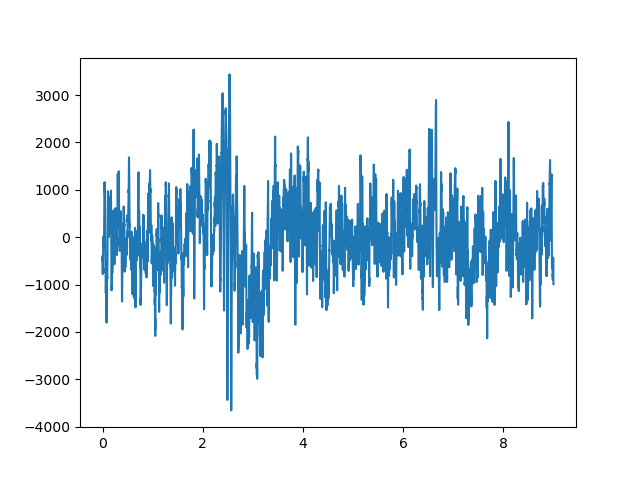

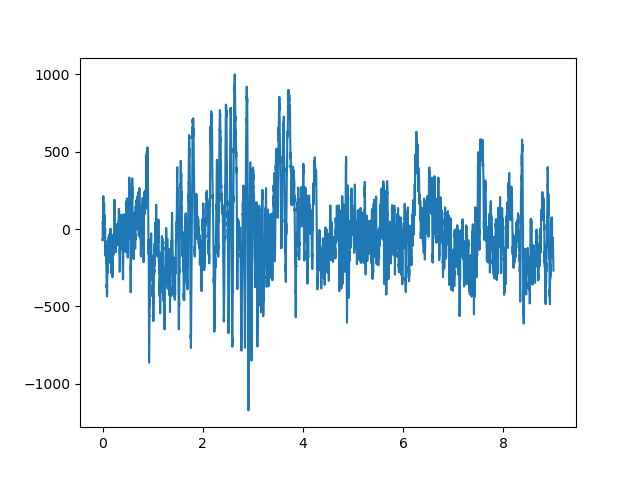

In [60]:
A0 = All2[:, 20]                    #EMG
A1 = All2[:, 28] - All2[:, 30]      #CA1 *
A2 = All2[:, 5] #- All2[:, 4]      #A1 *
A3 = All2[:, 2] - All2[:, 3]      #RSP *
A4 = All2[:, 24] - All2[:, 26]      #eog *
A5 = All2[:, 12] - All2[:, 11]      #PFC *
A6 = All2[:, 14] - All2[:, 15]      #S1 *

timestamp = 8978000
timeStart = timestamp - 3000
timeEnd = timestamp + 6000
fs = 1000
# Plot
times = np.arange(0, 9, 1/fs)

fig, ax = plt.subplots()
ax.plot(times, A2[timeStart:timeEnd])
plt.show()
filename = folder_base / f'A1-8978.svg'
plt.savefig(filename, format="svg")
plt.close()

fig, ax = plt.subplots()
ax.plot(times, A6[timeStart:timeEnd])
plt.show()
filename = folder_base / f'S1-8978.svg'
plt.savefig(filename, format="svg")
plt.close()


In [26]:
filename5 = folder_base / f'timestamps.npy'
Timestamps = np.load(filename5)
Timestamps = Timestamps*1000
Timestamps = Timestamps.astype(int)
dfTimestamps = pd.DataFrame(Timestamps, columns = ['stamps']) 
Timestamps2 = Timestamps.astype(int).tolist()

filenameTTL = folder_base / f'Timestamps.csv'
dfTimestamps.to_csv(filenameTTL, sep = ',')

In [7]:
Timestamps.astype(int)

array([11989432, 11989442, 11994650, 11994660, 11999867, 11999877,
       12005085, 12005095, 12010302, 12010312, 12015519, 12015529,
       12020737, 12020747, 12025954, 12025964, 12031172, 12031182,
       12036389, 12036399, 12041606, 12041616, 12046824, 12046834,
       12052041, 12052051, 12057258, 12057268, 12062476, 12062486,
       12067693, 12067703, 12072911, 12072921, 12078128, 12078138,
       12083345, 12083355, 12088563, 12088573, 12093780, 12093790,
       12098998, 12099008, 12104215, 12104225, 12109432, 12109442,
       12114650, 12114660, 12119867, 12119877, 12125085, 12125095,
       12130302, 12130312, 12135519, 12135529, 12140737, 12140747,
       12145954, 12145964, 12151172, 12151182, 12156389, 12156399,
       12161606, 12161616, 12166824, 12166834, 12172041, 12172051,
       12177258, 12177269, 12182476, 12182486, 12187693, 12187703,
       12192911, 12192921, 12198128, 12198138, 12203345, 12203355,
       12208563, 12208573, 12213780, 12213790, 12218998, 12219